In [ ]:
#Notebook to test normalisation during preprocessing

In [1]:
import numpy as np
import os
import sys
sys.path.append('/share/gpu0/jjwhit/rcGAN/')
from data.lightning.MassMappingDataModule import  MMDataTransform as MM

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

In [3]:
data_dir = '/share/gpu0/jjwhit/kappa_cosmos_simulations/cropped_dataset/kappa_train/'
files = os.listdir(data_dir)

In [4]:
mask = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_mask.npy', allow_pickle=True).astype(bool)
std1 = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_std1.npy', allow_pickle=True)
std2 = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_std2.npy', allow_pickle=True)

In [5]:
im_size=300

In [6]:
kernel = MM.compute_fourier_kernel(im_size)

In [7]:
kappa_mean = []
shear_mean = []
count=0
for file in files:
    data = np.load(os.path.join(data_dir, file))
    print(os.path.join(data_dir, file))
    kappa_mean.append(np.mean(data))
    #shear = MM.forward_model(data,kernel)
    #noisy_shear = shear + std1*np.random.randn(im_size,im_size) + 1.j * std2 * np.random.randn(im_size,im_size)
    #shear_mean.append(np.mean(noisy_shear))
    count+=1
    if count >=2:
        break

/share/gpu0/jjwhit/kappa_cosmos_simulations/cropped_dataset/kappa_train/cropped_sim_00001.npy
/share/gpu0/jjwhit/kappa_cosmos_simulations/cropped_dataset/kappa_train/cropped_sim_00002.npy


In [8]:
count

2

In [9]:
total_mean_kappa = np.mean(kappa_mean)

In [10]:
total_mean_kappa

0.0006848794665119482

In [11]:
std_i = 0
count=0
for file in files:
    data = np.load(os.path.join(data_dir, file))
    print(os.path.join(data_dir, file))
    kappa_i = (data-total_mean_kappa)**2
    std_i += np.sum(kappa_i)
    count+=1
    if count >=2:
        break

/share/gpu0/jjwhit/kappa_cosmos_simulations/cropped_dataset/kappa_train/cropped_sim_00001.npy
/share/gpu0/jjwhit/kappa_cosmos_simulations/cropped_dataset/kappa_train/cropped_sim_00002.npy


In [12]:
total_kappa_std = np.sqrt(std_i/(count*im_size**2))

In [13]:
total_kappa_std

0.0283255292883185

In [14]:
file1 = np.load('/share/gpu0/jjwhit/kappa_cosmos_simulations/cropped_dataset/kappa_train/cropped_sim_00001.npy', allow_pickle=True)
file2 = np.load('/share/gpu0/jjwhit/kappa_cosmos_simulations/cropped_dataset/kappa_train/cropped_sim_00002.npy', allow_pickle=True)
mean1 = np.mean(file1)
print('mean1 = ', mean1)
std1 = np.std(file1)
print('std1 = ', std1)

mean2 = np.mean(file2)
print('mean2 = ', mean2)
std2 = np.std(file2)
print('std2 = ', std2)

mean1 =  -0.004318266473496626
std1 =  0.02731789440843999
mean2 =  0.005688025406520522
std2 =  0.028431337031909927


# Testing normalisation

In [1]:
import sys
dir = '/home/jjwhit/rcGAN/'
sys.path.append(dir)

In [2]:
from typing import Dict, NamedTuple, Optional, Sequence, Tuple, Union
import numpy as np
import torch
from fastmri.data.subsample import MaskFunc
import matplotlib.pyplot as plt
import yaml
import types
import json

from data.lightning.MassMappingDataModule import MMDataModule
from utils.parse_args import create_arg_parser
from pytorch_lightning import seed_everything
from models.lightning.mmGAN import mmGAN
from utils.mri import transforms

/home/jjwhit/rcGAN/fastmri/__init__.py:16: UserWarning: Could not retrieve fastmri version!
  warnings.warn("Could not retrieve fastmri version!")


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
torch.cuda.get_device_properties(0).name

'NVIDIA A100 80GB PCIe'

In [5]:
def normalize(
    data: torch.Tensor,
    mean: Union[float, torch.Tensor],
    stddev: Union[float, torch.Tensor],
    eps: Union[float, torch.Tensor] = 0.0,
) -> torch.Tensor:
    """
    Normalize the given tensor.

    Applies the formula (data - mean) / (stddev + eps).

    Args:
        data: Input data to be normalized.
        mean: Mean value.
        stddev: Standard deviation.
        eps: Added to stddev to prevent dividing by zero.

    Returns:
        Normalized tensor.
    """
    return (data - mean) / (stddev + eps)


def normalize_instance(
    data: torch.Tensor, eps: Union[float, torch.Tensor] = 0.0
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Normalize the given tensor  with instance norm/

    Applies the formula (data - mean) / (stddev + eps), where mean and stddev
    are computed from the data itself.

    Args:
        data: Input data to be normalized
        eps: Added to stddev to prevent dividing by zero.

    Returns:
        torch.Tensor: Normalized tensor
    """

    mean = data.mean()
    std = data.std()

    return normalize(data, mean, std, eps), mean, std

def normalise_complex(
    shear: torch.Tensor, #Shape (2, H, W) 
    mag_mean: float = 0.14049194898307577,
    mag_std: float = 0.11606233247891737,
    eps: Union[float, torch.Tensor] = 0.0
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

    magnitude = torch.abs(torch.complex(shear[0,:,:], shear[1,:,:]))
    phase = torch.angle(torch.complex(shear[0,:,:], shear[1,:,:])) #In radians

    normal_mag = (magnitude - mag_mean) / (mag_std + eps)
    normal_shear = normal_mag * torch.exp(1j*phase)
    normal_real = normal_shear.real
    normal_imag = normal_shear.imag
    return torch.stack((normal_real, normal_imag)), mag_mean, mag_std

def unnormalize_complex(
    normed_data: torch.Tensor, 
    mag_mean: float = 0.14049194898307577, 
    mag_std: float = 0.11606233247891737,
):
    normed_mag = torch.abs(torch.complex(normed_data[0,:,:], normed_data[1,:,:]))
    phase = torch.angle(torch.complex(normed_data[0,:,:], normed_data[1,:,:]))
    # mag_data = ((normed_data * mag_std) / torch.exp(1j*phase)) + mag_mean
    # unnormed_data_real = mag_data * torch.cos(phase)
    # unnormed_data_imag = mag_data * torch.sin(phase)

    unnormed_mag = (normed_mag * mag_std) + mag_mean
    unnormed_data = unnormed_mag * torch.exp(1j*phase)
    unnormed_data_real = unnormed_data.real
    unnormed_data_imag = unnormed_data.imag
    return torch.stack((unnormed_data_real, unnormed_data_imag))

In [6]:
def compute_fourier_kernel(N: int) -> np.ndarray:
    """Computes the Fourier space kernel which represents the mapping between 
        convergence (kappa) and shear (gamma).

    Args:
        N (int): x,y dimension of image patch (assumes square images).

    Returns:
        D (np.ndarray): Fourier space Kaiser-Squires kernel, with shape = [N,N].
    """
    # Generate grid of Fourier domain
    kx = np.arange(N).astype(np.float64) - N/2
    kx, ky = np.meshgrid(kx, kx)
    k = kx**2 + ky**2
    # Define Kaiser-Squires kernel
    D = np.zeros((N, N), dtype=np.complex128)
    #D = np.where(k > 0, ((kx ** 2.0 - ky ** 2.0) + 1j * (2.0 * kx * ky))/k, D)
    # Another formulation to avoid divide by zero warning
    D[k>0] = (((kx ** 2.0 - ky ** 2.0) + 1j * (2.0 * kx * ky))[k>0]/k[k>0])
    # Apply inverse FFT shift 
    return np.fft.ifftshift(D)

def forward_model(kappa: np.ndarray, D: np.ndarray) -> np.ndarray:
    """Applies the forward mapping between convergence and shear through their 
        relationship in Fourier space.

    Args:
        kappa (np.ndarray): Convergence field, with shape [N,N].
        D (np.ndarray): Fourier space Kaiser-Squires kernel, with shape = [N,N].

    Returns:
        gamma (np.ndarray): Shearing field, with shape [N,N].
    """
    F_kappa = np.fft.fft2(kappa) # Perform 2D forward FFT
    F_gamma = F_kappa * D # Map convergence onto shear
    return np.fft.ifft2(F_gamma) # Perform 2D inverse FFT
def realistic_noise_maker(kappa: np.ndarray) -> np.ndarray:
    """Adds realistic simulated Gaussian noise to a mock weak lensing map.

    Args:
        im_size (int): Size of weak lensing map, in pixels.
        kappa (np.ndarray): Convergence map.
    
    Returns:
        gamma (np.ndarray): A synthetic representation of the shear field, gamma, with added noise.
    """
    im_size=300
    D = compute_fourier_kernel(im_size) #Fourier kernel
    gamma = forward_model(kappa, D) + (
        std1 * np.random.randn(im_size, im_size) 
        + 1.j * std2 * np.random.randn(im_size, im_size)
    )
    return gamma

In [7]:
mask = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_mask.npy', allow_pickle=True)
std1 = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_std1.npy', allow_pickle=True)
std2 = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_std2.npy', allow_pickle=True)

In [8]:
test_tensor_1 = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_shear_cropped.npy', allow_pickle=True) #cosmos shear
# test_tensor_2 = np.load('/share/gpu0/jjwhit/cropped_shear.npy', allow_pickle=True).astype(np.complex64)
test_tensor_2 = np.load('/share/gpu0/jjwhit/kappa_cosmos_simulations/cropped_dataset/kappa_val/cropped_sim_08985.npy', allow_pickle=True)

In [9]:
test_tensor_1.dtype

dtype('complex64')

In [10]:
test_tensor_2 = realistic_noise_maker(test_tensor_2)

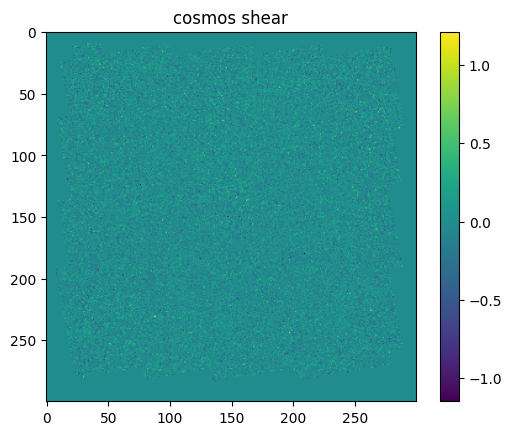

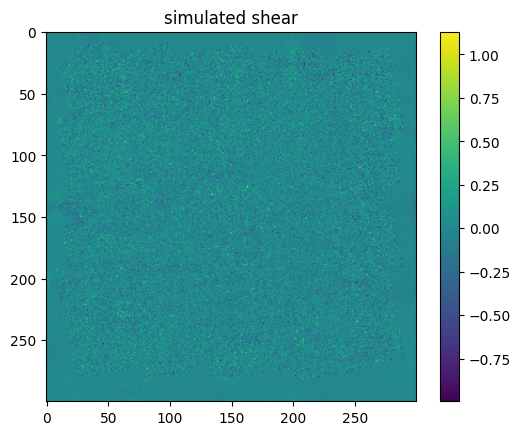

In [11]:
plt.imshow(test_tensor_1.real)
plt.colorbar()
plt.title('cosmos shear')
plt.show()
plt.imshow(test_tensor_2.real)
plt.colorbar()
plt.title('simulated shear')
plt.show()

In [11]:
test_tensor = np.stack((test_tensor_1, test_tensor_2), axis=0)
test_tensor = np.stack((test_tensor.real, test_tensor.imag), axis=-1)

In [12]:
test_tensor.shape

(2, 300, 300, 2)

In [13]:
test_tensor = torch.tensor(test_tensor).cuda()

In [14]:
normalised_gamma, mean, std = normalise_complex(test_tensor)

In [15]:
normalised_gamma[:, mask==0] = 0

In [16]:
normalised_gamma = normalised_gamma.permute(0,3,1,2).float()

In [17]:
normalised_gamma.shape

torch.Size([2, 2, 300, 300])

In [18]:
def load_object(dct):
    return types.SimpleNamespace(**dct)

In [19]:
torch.set_float32_matmul_precision('medium')

with open(dir+'configs/mass_map.yml', 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    cfg = json.loads(json.dumps(cfg), object_hook=load_object)

dm = MMDataModule(cfg)
fig_count = 1
dm.setup()
test_loader = dm.test_dataloader()

with torch.no_grad():
    mmGAN_model = mmGAN.load_from_checkpoint(
        checkpoint_path='/share/gpu0/jjwhit/mass_map/mm_models/mmgan_training_3/checkpoint_best.ckpt')

    mmGAN_model.cuda()

    mmGAN_model.eval()

In [20]:
gens_mmGAN = torch.zeros(size=(2,32, 300,300, 2)).cuda()
with torch.no_grad():
    print(mmGAN_model.forward(normalised_gamma).shape)
    for z in range(32):
        gens_mmGAN[:,z, :, :, :] = mmGAN_model.reformat(mmGAN_model.forward(normalised_gamma))

torch.Size([2, 2, 300, 300])


In [21]:
gens_mmGAN.shape

torch.Size([2, 32, 300, 300, 2])

In [23]:
avg_mmGAN = torch.mean(gens_mmGAN, dim=1)

In [24]:
kappa_mean = 0.00015744006243248638
kappa_std  = 0.02968584954283938

In [28]:
from scipy import ndimage
from utils.mri.math import tensor_to_complex_np

In [48]:
np_avgs_sim = {
    'mmGAN': None,
}

np_samps_sim = {
    'mmGAN': [],
}

np_stds_sim = {
    'mmGAN': None,
}


np_avgs_sim['mmGAN'] = ndimage.rotate(
    torch.tensor(tensor_to_complex_np((avg_mmGAN[1] * kappa_std + kappa_mean).cpu())).numpy(),
    180)
for z in range(32):
    np_samps_sim['mmGAN'].append(ndimage.rotate(torch.tensor(
        tensor_to_complex_np((gens_mmGAN[1, z] * kappa_std + kappa_mean).cpu())).numpy(), 180))

np_stds_sim['mmGAN'] = np.std(np.stack(np_samps_sim['mmGAN']), axis=0)

np_avgs_cos = {
    'mmGAN': None,
}

np_samps_cos = {
    'mmGAN': [],
}

np_stds_cos = {
    'mmGAN': None,
}


np_avgs_cos['mmGAN'] = ndimage.rotate(
    torch.tensor(tensor_to_complex_np((avg_mmGAN[0] * kappa_std + kappa_mean).cpu())).numpy(),
    180)
for z in range(32):
    np_samps_cos['mmGAN'].append(ndimage.rotate(torch.tensor(
        tensor_to_complex_np((gens_mmGAN[0, z] * kappa_std + kappa_mean).cpu())).numpy(), 180))

np_stds_cos['mmGAN'] = np.std(np.stack(np_samps_cos['mmGAN']), axis=0)

In [59]:
np.save('/share/gpu0/jjwhit/samples/np_avgs_cos.npy', np_avgs_cos['mmGAN'])
np.save('/share/gpu0/jjwhit/samples/np_stds_cos.npy', np_stds_cos['mmGAN'])
np.save('/share/gpu0/jjwhit/samples/np_samps_cos.npy', np_samps_cos['mmGAN'])

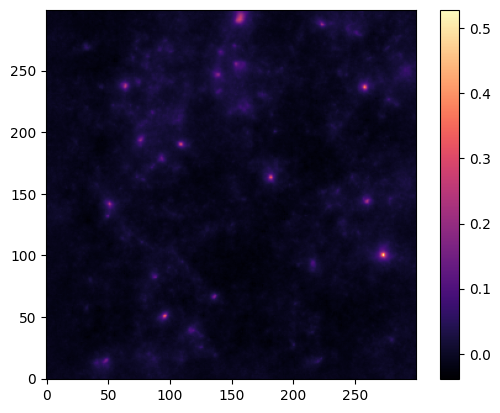

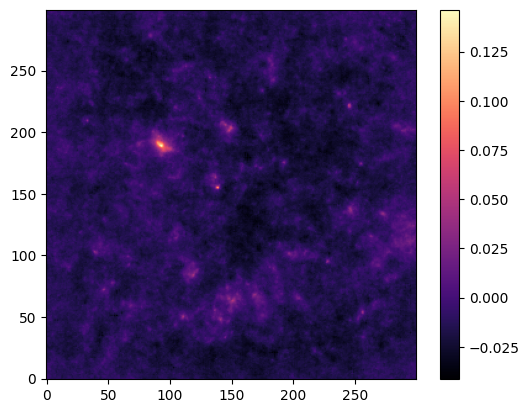

In [49]:
plt.imshow(np_avgs_sim['mmGAN'].real, cmap='magma', origin='lower')
plt.colorbar()
plt.show()
plt.imshow(np_avgs_cos['mmGAN'].real, cmap='magma', origin='lower')
plt.colorbar()
plt.show()

In [40]:
gt = np.load('/share/gpu0/jjwhit/kappa_cosmos_simulations/cropped_dataset/kappa_val/cropped_sim_08985.npy', allow_pickle=True)

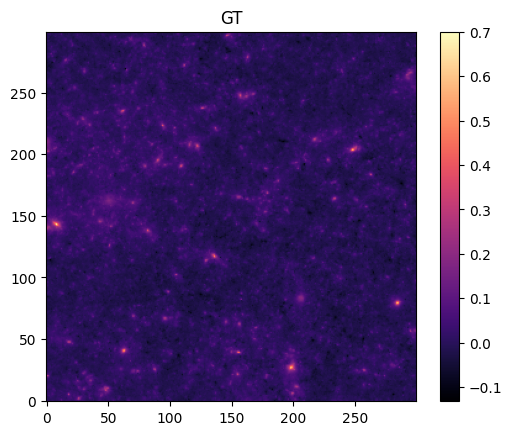

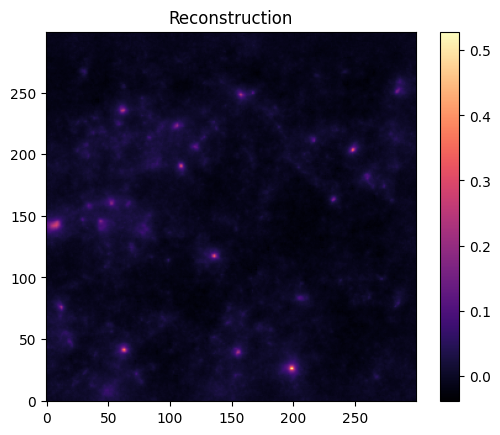

In [57]:
plt.imshow(gt, cmap='magma', origin='lower')
plt.colorbar()
plt.title('GT')
plt.show()
plt.imshow(np.flipud(np.rot90((np_avgs_sim['mmGAN'].real),k=3)), cmap='magma', origin='lower')
plt.colorbar()
plt.title('Reconstruction')
plt.show()

In [26]:
test_tensor = torch.tensor(np.stack((test_tensor.real * 0.75, test_tensor.imag * 0.75), axis=0))

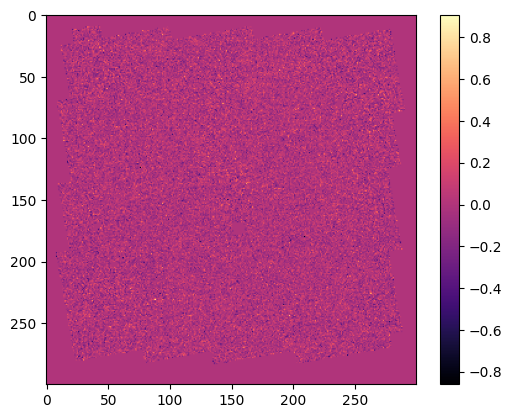

In [27]:
plt.imshow(test_tensor[0], cmap='magma')
plt.colorbar()

In [28]:
simple_tensor, simple_mean, simple_std= normalize_instance(test_tensor)

In [29]:
print("simple mean is: ", simple_mean)
print("simple std is: ", simple_std)
print("simple tensor has shape:  ",simple_tensor.shape)

simple mean is:  tensor(0.0002)
simple std is:  tensor(0.0976)
simple tensor has shape:   torch.Size([2, 300, 300])


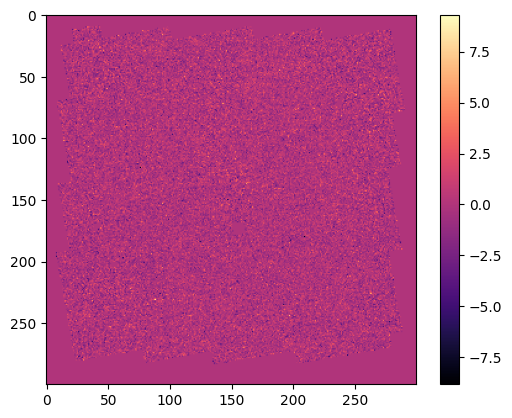

In [30]:
plt.imshow(simple_tensor[0], cmap='magma') #Tends to  normalise to about 7/8 magnitude
plt.colorbar()

In [31]:
complicated_tensor,complicated_mean,complicated_std = normalise_complex(test_tensor)

In [32]:
print("complicated mean is: ", complicated_mean)
print("complicated std is: ", complicated_std)
print("complicated tensor has shape:  ",complicated_tensor.shape)

complicated mean is:  0.14049194898307577
complicated std is:  0.11606233247891737
complicated tensor has shape:   torch.Size([2, 300, 300])


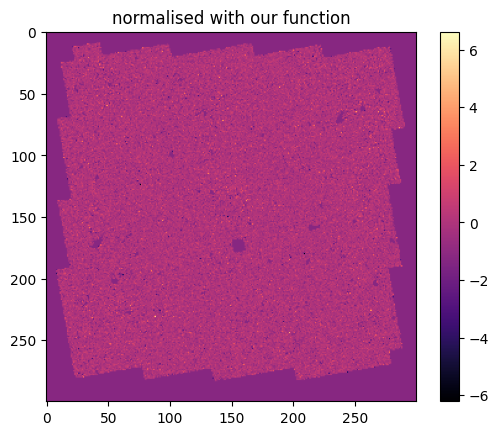

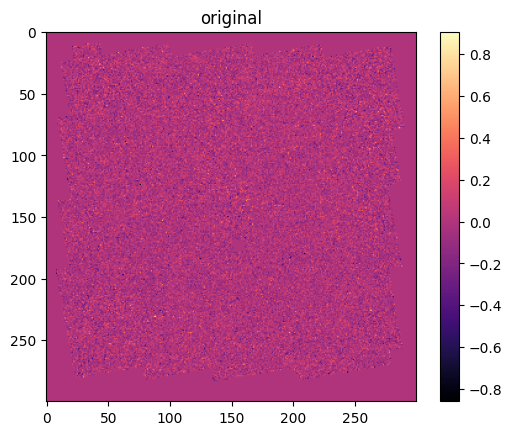

In [33]:
plt.imshow(complicated_tensor[0], cmap='magma')
plt.colorbar()
plt.title('normalised with our function')
plt.show()
plt.imshow(test_tensor[0], cmap='magma')
plt.colorbar()
plt.title('original')
plt.show()

In [174]:
mag_mean = 0.14049194898307577
mag_std = 0.11606233247891737

In [34]:
full_tensor = (torch.complex(test_tensor[0,:,:], test_tensor[1,:,:]))

In [35]:
full_tensor.shape

torch.Size([300, 300])

In [36]:
full_tensor[150:170, 150:170]

tensor([[ 0.0908+0.1225j,  0.0000+0.0000j, -0.0052+0.0348j, -0.1381-0.1151j,
         -0.0390+0.1195j, -0.0291-0.0072j, -0.4879+0.1410j, -0.1049+0.0932j,
         -0.0552+0.1183j,  0.0227-0.0471j, -0.1977-0.2620j,  0.1192-0.1375j,
          0.0989-0.1456j, -0.0789+0.0886j,  0.1307+0.0032j,  0.0385+0.2024j,
          0.0104+0.2036j,  0.0426-0.0432j, -0.0797+0.0181j, -0.0777-0.1421j],
        [-0.1003+0.1733j, -0.2509+0.0332j,  0.1875-0.1833j, -0.1973-0.1402j,
          0.0905-0.2582j,  0.0742-0.0354j, -0.0808+0.1894j,  0.1048+0.0490j,
         -0.0032-0.1458j,  0.1006-0.1021j,  0.1537+0.0625j,  0.0221+0.1396j,
         -0.0570-0.0137j, -0.0516+0.0773j,  0.5035-0.1415j, -0.0527-0.1296j,
          0.0202-0.1023j, -0.0098+0.0934j,  0.0561-0.2623j, -0.0187+0.1197j],
        [ 0.2027+0.0657j,  0.0471-0.0483j, -0.0239+0.0483j, -0.1285-0.1470j,
         -0.0195-0.0022j, -0.0762+0.2162j,  0.0135+0.0372j,  0.1269+0.0746j,
         -0.2796+0.1482j,  0.0159-0.0609j, -0.0421-0.0075j,  0.1590-0.0645

In [184]:
magnitude = torch.abs(full_tensor)

In [185]:
phase = torch.angle(torch.complex(test_tensor[0,:,:], test_tensor[1,:,:]))

In [186]:
phase[150:170, 150:170]

tensor([[ 0.9329,  0.0000,  1.7195, -2.4470,  1.8864, -2.8973,  2.8603,  2.4150,
          2.0072, -1.1218, -2.2173, -0.8564, -0.9743,  2.2988,  0.0242,  1.3828,
          1.5199, -0.7917,  2.9189, -2.0710],
        [ 2.0953,  3.0101, -0.7741, -2.5237, -1.2338, -0.4453,  1.9741,  0.4374,
         -1.5930, -0.7930,  0.3865,  1.4138, -2.9055,  2.1593, -0.2740, -1.9573,
         -1.3755,  1.6753, -1.3603,  1.7258],
        [ 0.3133, -0.7975,  2.0299, -2.2891, -3.0280,  1.9098,  1.2218,  0.5317,
          2.6541, -1.3150, -2.9659, -0.3854,  1.5448,  1.7981, -1.6149, -0.2747,
          0.3828, -0.6397, -0.4994,  2.2708],
        [-2.7768,  0.8816, -1.1069,  0.5816,  0.1691, -3.0375, -2.8355,  2.5626,
         -2.4490, -2.3885,  1.5973,  2.5084,  2.7148, -1.1629, -0.9008,  2.7337,
          1.4026, -1.9045, -1.5320,  1.6787],
        [-2.4869,  0.6689, -1.5569,  0.7992, -1.5015,  0.0486, -2.1495,  2.6045,
         -0.4751,  0.6264,  1.5319,  1.6549, -1.3141,  2.0042, -2.5070,  1.5385,
      

In [187]:
normal_mag_num = (magnitude - mag_mean) / (mag_std) #mag_std is typically small, so this causes the magnitude to become quic

In [188]:
normal_mag_num[150:170, 150:170]

tensor([[ 5.4192e-01, -1.2105e+00, -8.0585e-01,  8.5472e-01,  2.3327e-01,
         -8.6634e-01,  4.6240e+00,  4.0194e-01,  2.8918e-01, -6.1007e-01,
          2.5603e+00,  8.7975e-01,  8.1178e-01,  1.5222e-01,  2.9155e-01,
          1.1562e+00,  1.1319e+00, -5.1340e-01, -2.7124e-01,  6.5014e-01],
        [ 1.0897e+00,  1.6966e+00,  1.8016e+00,  1.5705e+00,  1.9328e+00,
         -2.6570e-01,  1.1547e+00,  1.1919e-01,  4.6479e-01,  4.3644e-01,
          6.9600e-01,  4.1340e-01, -5.3700e-01, -1.4255e-01,  4.7974e+00,
          3.9700e-01, -1.2406e-02, -1.3207e-01,  1.8709e+00,  1.8124e-01],
        [ 1.2377e+00, -4.3573e-01, -5.9150e-01,  1.0321e+00, -9.8463e-01,
          1.4237e+00, -7.5548e-01,  4.8094e-01,  2.4248e+00, -4.8730e-01,
         -7.1978e-01,  7.6084e-01, -6.0851e-01,  9.4039e-01,  9.7807e-01,
          1.3094e-01,  1.6640e+00,  2.2305e-01, -1.3508e-01, -1.9033e-01],
        [-3.5325e-01, -2.2707e-01, -2.5485e-01, -1.4766e-01, -4.0382e-02,
          8.4982e-01, -5.5500e-01, 

In [192]:
normal_shear = normal_mag_num * torch.exp(1j*phase)

In [193]:
normal_shear[150:170,150:170] #Phase goes back to what it was before

tensor([[ 3.2272e-01+4.3535e-01j, -1.2105e+00+0.0000e+00j,
          1.1942e-01-7.9695e-01j, -6.5669e-01-5.4709e-01j,
         -7.2404e-02+2.2175e-01j,  8.4061e-01+2.0955e-01j,
         -4.4422e+00+1.2837e+00j, -3.0043e-01+2.6702e-01j,
         -1.2223e-01+2.6208e-01j, -2.6479e-01+5.4961e-01j,
         -1.5423e+00-2.0436e+00j,  5.7636e-01-6.6465e-01j,
          4.5600e-01-6.7160e-01j, -1.0128e-01+1.1364e-01j,
          2.9146e-01+7.0633e-03j,  2.1605e-01+1.1359e+00j,
          5.7603e-02+1.1305e+00j, -3.6072e-01+3.6532e-01j,
          2.6454e-01-5.9901e-02j, -3.1183e-01-5.7048e-01j],
        [-5.4566e-01+9.4322e-01j, -1.6820e+00+2.2245e-01j,
          1.2882e+00-1.2595e+00j, -1.2801e+00-9.0981e-01j,
          6.3910e-01-1.8241e+00j, -2.3979e-01+1.1445e-01j,
         -4.5310e-01+1.0620e+00j,  1.0797e-01+5.0486e-02j,
         -1.0308e-02-4.6468e-01j,  3.0625e-01-3.1095e-01j,
          6.4467e-01+2.6233e-01j,  6.4642e-02+4.0831e-01j,
          5.2210e-01+1.2563e-01j,  7.9125e-02-1.1857e-0

In [194]:
final_tensor, final_mean, final_std = torch.stack((normal_shear.real, normal_shear.imag)), mag_mean, mag_std

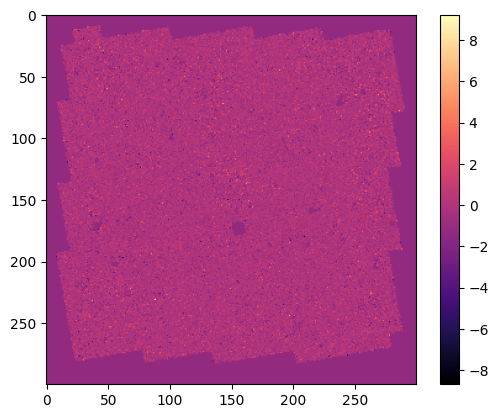

In [200]:
plt.imshow(final_tensor[0], cmap='magma')
plt.colorbar()

In [201]:
final_tensor.shape

torch.Size([2, 300, 300])

In [203]:
torch.save(final_tensor,'/home/jjwhit/rcGAN/mass_map_utils/cosmos/test_cosmos_shear_normalised')

In [196]:
original_tensor = unnormalize_complex(final_tensor)

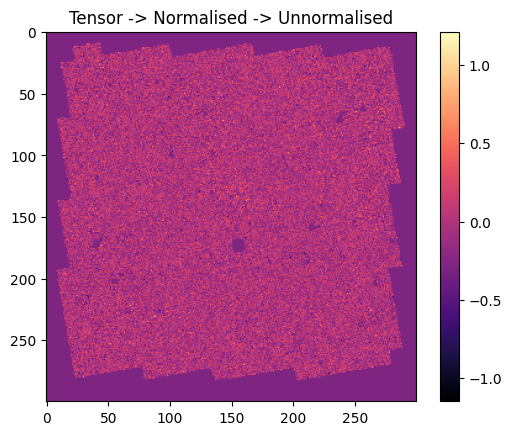

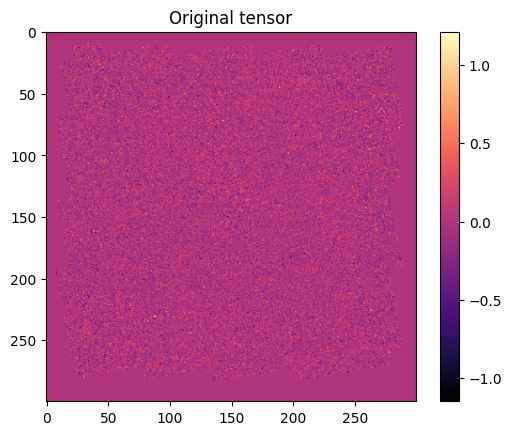

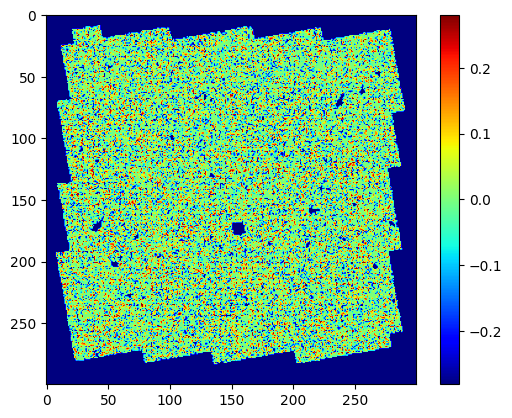

In [197]:
plt.imshow(original_tensor[0], cmap='magma')
plt.colorbar()
plt.title('Tensor -> Normalised -> Unnormalised')
plt.show()
plt.imshow(test_tensor[0], cmap='magma')
plt.title('Original tensor')
plt.colorbar()
plt.show()
plt.imshow(original_tensor[0]-test_tensor[0], cmap='jet')
plt.colorbar()
plt.show()